In [109]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [110]:
# Parameters

##### release position 
release_zone = "test_1500"
bathymodiolus_delta_lat = 0.6  #seamount diameter

release_depth = 1500

# release particles
number_particles = 12000

# release timing
release_time_in_days = 3   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 3
start_day = 1

# experiment duration etc
runtime_in_days = 42
dt_in_minutes = -60

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "../data/config/test_stations.csv"

# location of input data
data_path = '../data/config/'#'/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'ROMS' 
data_resolution = '1d'
mesh_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'

# names of files to load
fname = 'roms_avg*_2009_datetime.nc'
depthfile = 'sigma2depth_parent.nc'
meshfile = 'roms_grd2_1500mVT1.nc'

# location of output data
outpath = f'../output_data/{experiment_name}'
output_filename = 'Column_backwards_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [111]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [112]:
data_path = Path(data_path)
mesh_path = Path(mesh_path)
depth_path = data_path
#mesh_mask = mask_path / experiment_name / fname

outpath = Path(outpath)

output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename
outfile

PosixPath('../output_data/ROMS/Column_backwards_test_1500_20090301_RT-42_N-12000_seed-12345.nc')

### Load release location

In [113]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [114]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 1500.0)

### Fieldset

In [115]:
def fieldset_definitions(
    data_file, mesh_file, depth_file 
):
    
    filenames = {'U': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'V': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'WA': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'T': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                }

    variables = {'U': 'u', 'V': 'v', 'WA': 'w', 'T': 'temp'}
    
    dimensions = {'U': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs',
                       'time': 'time'},  # needs to be on f-nodes (psi)
                  'V': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs',
                        'time': 'time'},  # needs to be on f-nodes (psi)
                  'WA': {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs',
                        'time': 'time'},  # needs to be on f-nodes (psi)
                  'T': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'hs',
                        'time': 'time'},  # needs to be on t-nodes (rho)
                 }  

    return FieldSet.from_c_grid_dataset(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

In [116]:
def create_fieldset(
    data_path=data_path, mesh_path=mesh_path, depth_path=depth_path, experiment_name=experiment_name,
    fname=fname, meshfile=meshfile, depthfile=depthfile
):
    
    data = list(sorted((data_path / experiment_name).glob(fname)))
    mesh = list(sorted((mesh_path / experiment_name).glob(meshfile)))
    depth = list(sorted((depth_path / experiment_name).glob(depthfile)))
    
    fieldset = fieldset_definitions(
        data, mesh, depth)
    return fieldset

In [117]:
fieldset = create_fieldset()

/opt/conda/lib/python3.10/site-packages/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/opt/conda/lib/python3.10/site-packages/parcels/field.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))
/opt/conda/lib/python3.10/site-packages/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

In [118]:
print(type(fieldset.U.grid))
assert fieldset.U.grid is fieldset.V.grid
assert fieldset.U.grid is fieldset.WA.grid

<class 'parcels.grid.RectilinearSGrid'>


In [119]:
fieldset.computeTimeChunk(time=fieldset.U.grid.time[0], dt=1)
print(fieldset.U.data.shape)
print(fieldset.U.grid.lon.shape)
print(fieldset.U.grid.lat.shape)
print(fieldset.U.grid.depth.shape)

(2, 32, 257, 237)
(237,)
(257,)
(32, 257, 237)


In [120]:
fieldset.WA.set_scaling_factor(-1)

In [121]:
fieldset

In [122]:
print(fieldset.U.grid.depth[:,20,0])

[1396.8757   1384.7084   1369.9467   1352.1112   1330.6694   1305.0474
 1274.6512   1238.9001   1197.2747   1149.3776   1095.0068   1034.2303
  967.45197   895.4517    819.3852    740.73145   661.18933   582.5356
  506.4691    434.46884   367.69043   306.91394   252.5432    204.64613
  163.02061   127.269585   96.8734     71.25141    49.809605   31.974112
   17.212467    5.045076]


### Create a set of particles with random initial positions

In [123]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / abs(dt_in_minutes), size=(number_particles, )
        )
)

In [124]:
def get_uniform_random_in_cube(
    lat_start=bathymodiolus_lat-bathymodiolus_delta_lat, lat_end=bathymodiolus_lat+bathymodiolus_delta_lat,
    lon_start=bathymodiolus_lon-bathymodiolus_delta_lon, lon_end=bathymodiolus_lon+bathymodiolus_delta_lon,
    release_depth=release_depth,
    N=10,
):
    lat = np.rad2deg(
        np.arcsin(
            np.random.uniform(
                np.sin(np.deg2rad(lat_start)),
                np.sin(np.deg2rad(-22.9)),      # eigentlich lat_end statt -22.9
                size=(N, ),
            )
        )
    )
    lon = np.random.uniform(lon_start, lon_end, size=(N, ))
    depth = np.random.uniform(0,release_depth, size=(N, ))
    
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
            "depth": depth,
        }
    )

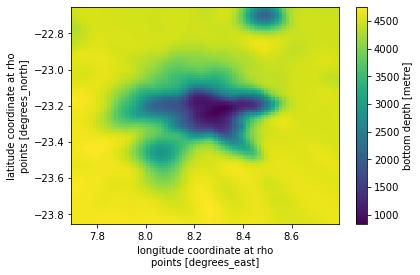

In [125]:
SIGMA=xr.open_dataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})

topo_ROMS.sel(lat=slice(bathymodiolus_lat-bathymodiolus_delta_lat,
                         bathymodiolus_lat+bathymodiolus_delta_lat,None),
               lon=slice(bathymodiolus_lon-bathymodiolus_delta_lon,
                         bathymodiolus_lon+bathymodiolus_delta_lon,None)).plot();

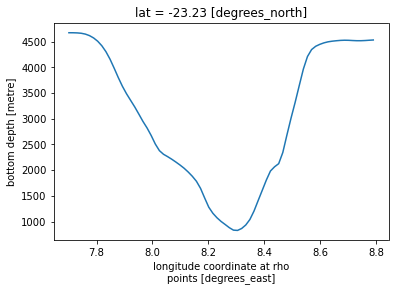

In [126]:
topo_ROMS.isel(lat=129).sel( #-23.23
               lon=slice(bathymodiolus_lon-bathymodiolus_delta_lon,
                         bathymodiolus_lon+bathymodiolus_delta_lon,None)).plot()

In [127]:
print(topo_ROMS.sel(lat=slice(bathymodiolus_lat-bathymodiolus_delta_lat,
                         bathymodiolus_lat+bathymodiolus_delta_lat,None),
               lon=slice(bathymodiolus_lon-bathymodiolus_delta_lon,
                         bathymodiolus_lon+bathymodiolus_delta_lon,None)).min());

<xarray.DataArray 'h' ()>
array(827.97241211)


In [128]:
release_points = get_uniform_random_in_cube(N=200*number_particles,
)
release_points["topo_ROMS"] = topo_ROMS.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where((release_points.topo_ROMS > release_points.depth + 50) & (  # at least 50 meters above ground
    release_points.topo_ROMS < release_depth)).dropna().iloc[
    :number_particles].reset_index(drop=True)

In [129]:
release_points

,lat,lon,depth,topo_ROMS
0,-23.172143,8.303916,670.393967,1203.521973
1,-23.176698,8.303679,249.475389,1203.521973
2,-23.155572,8.281792,484.297204,1263.495850
3,-23.226955,8.312384,350.325171,865.415955
4,-23.161187,8.197567,498.290751,1136.859741
...,...,...,...,...
11995,-23.197302,8.437808,507.055484,1315.949097
11996,-23.287856,8.209625,776.259608,1294.195435
11997,-23.284040,8.314146,42.810557,1167.016479
11998,-23.250893,8.194885,588.312801,1299.388306


In [130]:
print(release_points['topo_ROMS'].min())
print(release_points['topo_ROMS'].max())

827.972412109375
1493.6085205078125


In [131]:
print(time[0:3])

[datetime.datetime(2009, 3, 1, 0, 0) datetime.datetime(2009, 3, 1, 0, 0)
 datetime.datetime(2009, 3, 1, 0, 0)]


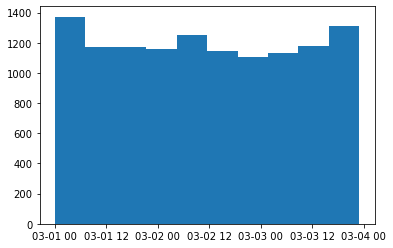

In [132]:
plt.hist(time, bins=10);

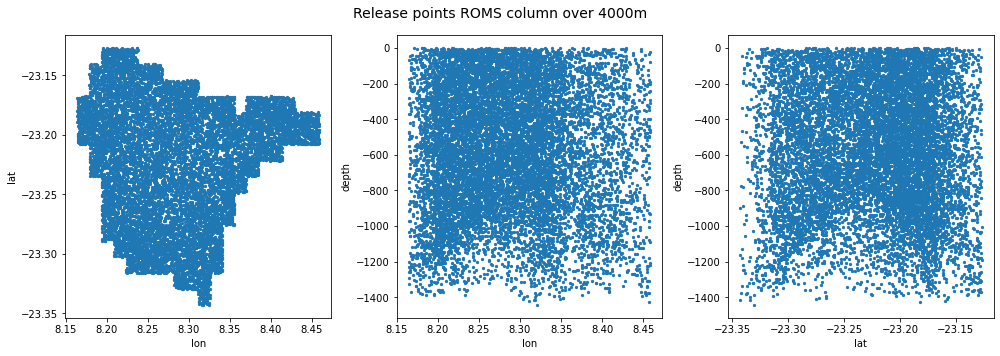

In [133]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.scatter(release_points.lon, release_points.lat, s=5)
plt.xlabel('lon')
plt.ylabel('lat')
plt.subplot(1,3,2)
plt.scatter(release_points.lon, -release_points.depth, s=5)
plt.xlabel('lon')
plt.ylabel('depth')
plt.subplot(1,3,3)
plt.scatter(release_points.lat, -release_points.depth, s=5)
plt.xlabel('lat')
plt.ylabel('depth')

fig.suptitle('Release points ROMS column over 4000m',fontsize = 14)
fig.tight_layout()

#plt.savefig(('../output_data/{experiment_name}/plots/release-points_column_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.png').format(
#    experiment_name = experiment_name,
#    release_zone = release_zone,
#    RNG_seed=RNG_seed,
#    start_year=start_year,
#    start_month = start_month,
#    start_day = start_day,
#    runtime_in_days = runtime_in_days,
#    number_particles=number_particles)
#           )

plt.show;

In [134]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle, #SampleParticle später? muss dann vorher auch def werden,
    lat=release_points.lat,
    lon=release_points.lon,
    depth=release_points.depth,
    time=time
)
print(pset[0])

P[150000](lon=8.303916, lat=-23.172143, depth=670.393967, time=5097600.000000)
CPU times: user 89.2 ms, sys: 1.02 ms, total: 90.2 ms
Wall time: 89.6 ms


In [135]:
#https://github.com/OceanParcels/parcels/issues/765
def AdvectionRK4_3D_alternative(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration with vertical velocity independent of vertical grid distortion.

    Function needs to be converted to Kernel object before execution"""
    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    w1 = fieldset.WA[time, particle.depth, particle.lat, particle.lon]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + w1*.5*particle.dt
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, dep1, lat1, lon1]
    w2 = fieldset.WA[time + .5 * particle.dt, dep1, lat1, lon1]
    lon2 = particle.lon + u2*.5*particle.dt
    lat2 = particle.lat + v2*.5*particle.dt
    dep2 = particle.depth + w2*.5*particle.dt
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, dep2, lat2, lon2]
    w3 = fieldset.WA[time + .5 * particle.dt, dep2, lat2, lon2]
    lon3 = particle.lon + u3*particle.dt
    lat3 = particle.lat + v3*particle.dt
    dep3 = particle.depth + w3*particle.dt
    (u4, v4) = fieldset.UV[time + particle.dt, dep3, lat3, lon3]
    w4 = fieldset.WA[time + particle.dt, dep3, lat3, lon3]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    particle.depth += (w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt

In [136]:
kernel = pset.Kernel(AdvectionRK4_3D_alternative)

### Be able to handle errors during integration

In [137]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.ErrorThroughSurface: DeleteParticle
    }

In [138]:
outfile

PosixPath('../output_data/ROMS/Column_backwards_test_1500_20090301_RT-42_N-12000_seed-12345.nc')

In [139]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [140]:
pset.execute(
    kernel,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
    recovery=recovery_cases,
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D_alternative ==> /tmp/parcels-726810/libb382550b8d901f533008de97ff0ff1ba_0.so
INFO: Temporary output files are stored in ../output_data/ROMS/out-GARPUIYJ.
INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/ROMS/out-GARPUIYJ" to convert these to a NetCDF file during the run.
100%|██████████████████████████| 3888000.0/3888000.0 [00:45<00:00, 84951.24it/s]


### Errors at bottom:
* Particle P[23](lon=8.339165, lat=-23.223385, depth=936.193193, time=216000.000000)
  
  Time: 2009-01-03T12:00:00.000000000,	timestep dt: 3600.000000
  
  Through-surface sampling by particle at (8.339165, -23.223385, 936.193193)

### Errors at surface:
* Particle P[4](lon=8.254837, lat=-23.426231, depth=10.000000, time=0.000000)
   
  Time: 2009-01-01T00:00:00.000000000,	timestep dt: 3600.000000
  
  Out-of-bounds sampling by particle at (8.254837, -23.426231, 10.000000)

In [141]:
output_pfile.export()

In [142]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 12000, obs: 46)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

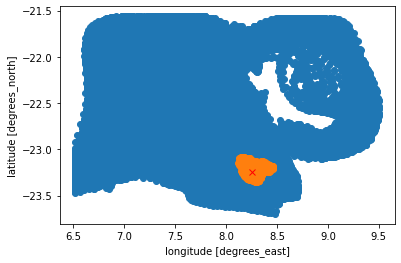

In [143]:
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

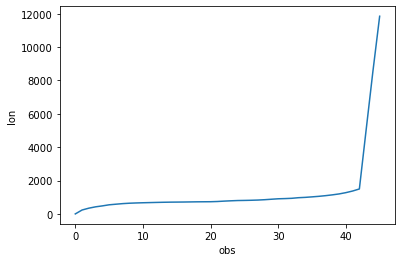

In [144]:
particle_ds.lon.isnull().sum("traj").plot()